This notebook is a playground for experimenting with the following:

* `Ranger` optimizer (`RAdam` + `Lookahead`)
* `LabelSmoothingCrossEntropy()` loss function
* `fit_with_annealing`

**To summarise, using `Ranger` and `LabelSmoothingCrossEntropy()` gives us an improvement of roughly 2%**

In [1]:
%reload_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [8]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback, CSVLogger
from ranger import *

from CinemaNet.train_utils import *
from CinemaNet.wandb import *
from CinemaNet.MixMatch import *
from CinemaNet.data_3000L import *
from CinemaNet.blend import *
from CinemaNet.custom_head import *

import wandb

In [36]:
# Source: https://github.com/lessw2020/Ranger-Mish-ImageWoof-5/blob/master/train.py
def fit_with_annealing(learn:Learner, num_epoch:int, lr:float=defaults.lr, annealing_start:float=0.7)->None:
    n = len(learn.data.train_dl)
    anneal_start = int(n*num_epoch*annealing_start)
    phase0 = TrainingPhase(anneal_start).schedule_hp('lr', lr)
    phase1 = TrainingPhase(n*num_epoch - anneal_start).schedule_hp('lr', lr, anneal=annealing_cos)
    phases = [phase0, phase1]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    learn.fit(num_epoch)

In [4]:
model_name = 'MNetV2-150x266-3000L'

## Load Dataset

Data grabbing functions in `CinemaNet/data_3000L.py`

In [5]:
img_size   = to_film_ar(150)

In [6]:
data = get_data_3000L(img_size)
data

ImageDataBunch;

Train: LabelList (3000 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Close-Up,Close-Up,Close-Up,Close-Up,Close-Up
Path: .;

Valid: LabelList (3105 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Close-Up,Medium,Extreme Wide,Medium,Extreme Close-Up
Path: .;

Test: None

6

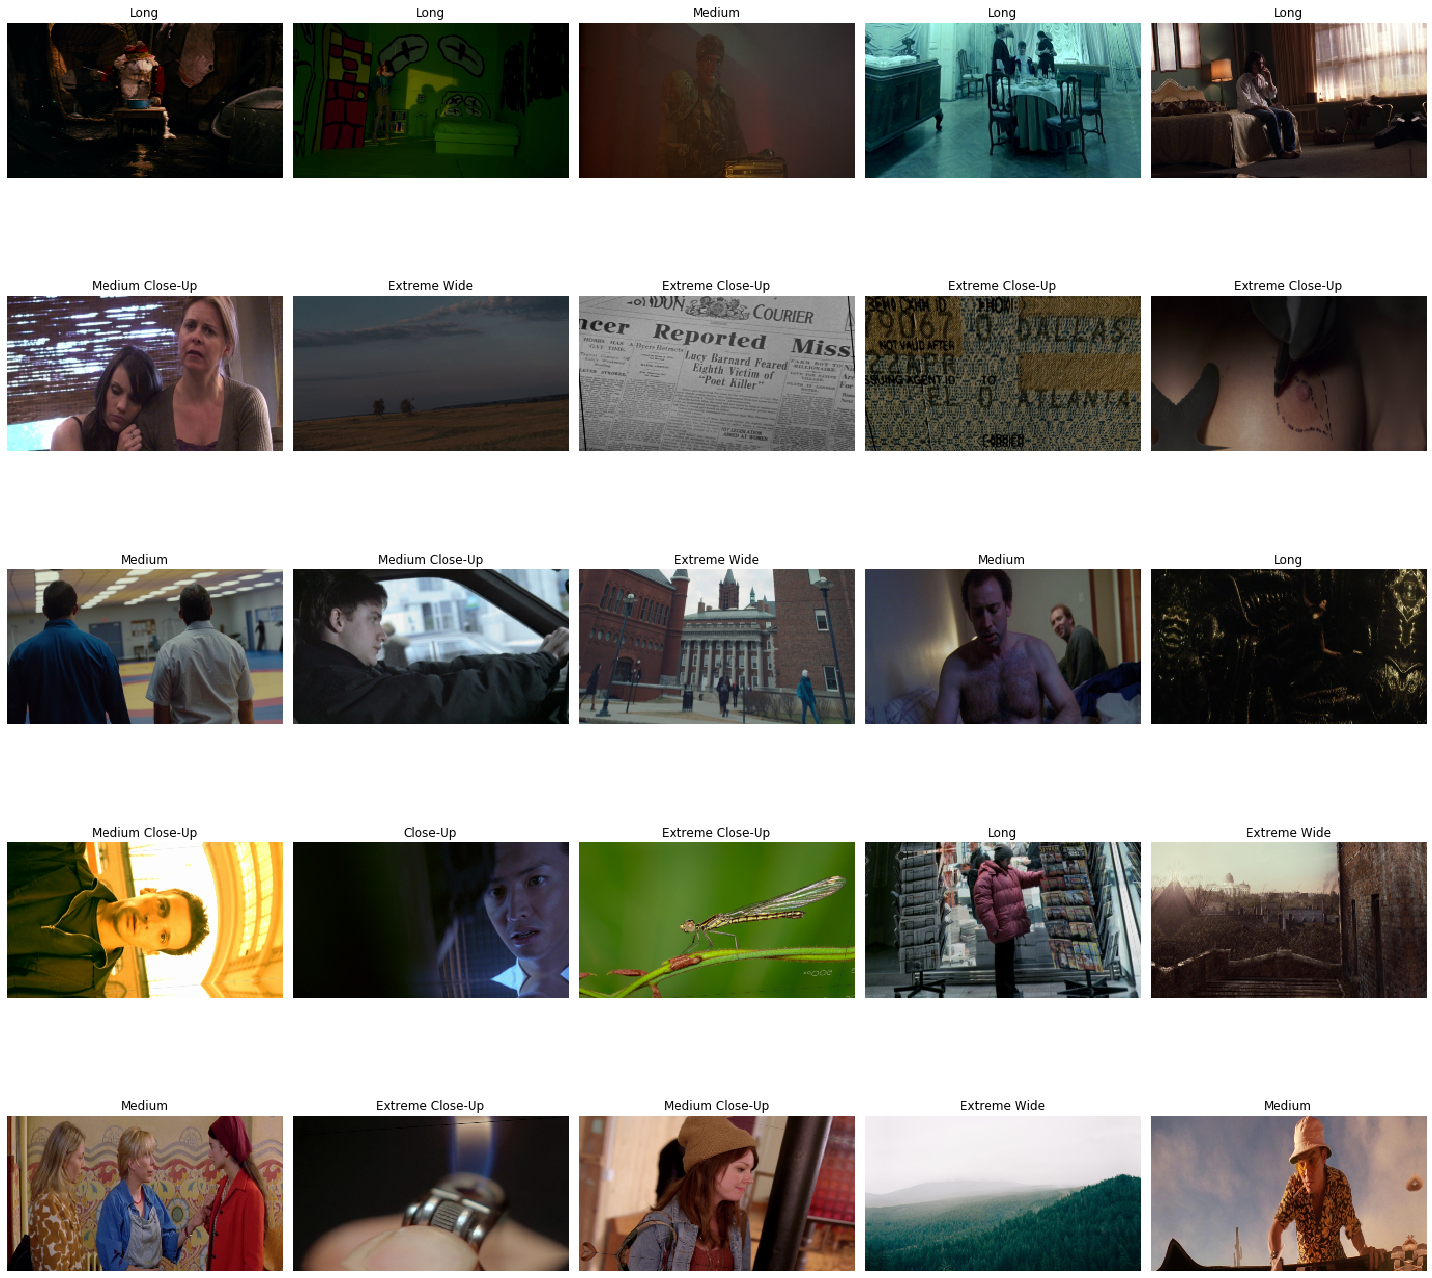

In [8]:
data.c
data.show_batch()

In [42]:
img_size

(150, 266)

## Ranger + Label Smoothing + Fit w/ Annealing

The pretrained model is trained end-to-end at once (as oppposed to fitting the head, then unfreezing) and the head is unchanged. <br>
Peaks at **88.6%**, which is already better than our previous supervised baseline model (`MNetV2-150x266-3000L` @86.7%)

In [10]:
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *

In [37]:
model     = models.mobilenet_v2(pretrained=True)
opt_func  = Ranger
loss_func = LabelSmoothingCrossEntropy()
bs = 64

In [32]:
learn = Learner(data, model, opt_func, loss_func, metrics, bn_wd=False)

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03
Min loss divided by 10: 3.31E-01


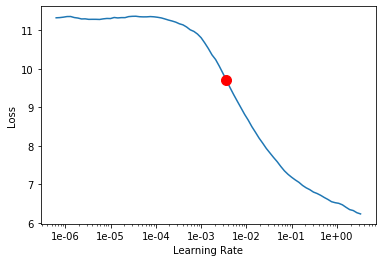

In [34]:
learn.lr_find(wd=1e-2)
learn.recorder.plot(suggestion=True)

In [35]:
fit_with_annealing(learn, num_epoch=10, lr=3e-3, annealing_start=0.72)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,3.590088,2.384199,0.723994,nan,nan,00:50
1,2.172274,1.530901,0.852174,nan,nan,00:49
2,1.681560,1.400666,0.885346,nan,nan,00:46
3,1.462247,1.374410,0.880193,nan,nan,00:48
4,1.359075,1.412378,0.870853,nan,nan,00:48
5,1.296845,1.374311,0.875684,nan,nan,00:48
6,1.260885,1.371275,0.883414,nan,nan,00:48
7,1.217848,1.390532,0.876651,nan,nan,00:48
8,1.175918,1.376268,0.885990,nan,nan,00:46
9,1.143392,1.380798,0.882126,nan,nan,00:49


/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


## Ranger + Label Smoothing + Fit w/ Annealing + New Head + Learning in Stages

Learning in Stages = fitting the head first, then unfreezing and fine-tuning the entire model. <br>
Peaks at **87.4%**

In [85]:
model     = models.mobilenet_v2(pretrained=True)
opt_func  = Ranger
loss_func = LabelSmoothingCrossEntropy()
bs = 64

In [107]:
learn = cnn_learner(data, models.mobilenet_v2, bn_wd=False, pretrained=True,
                    metrics=metrics, opt_func=opt_func, loss_func=loss_func,
                    callback_fns = partial(SaveModelCallback, monitor='accuracy'))

set state called
set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-03
Min loss divided by 10: 6.31E-02


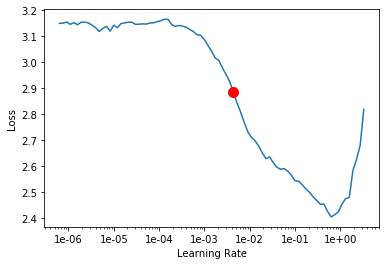

In [108]:
learn.lr_find(wd=1e-2)
learn.recorder.plot(suggestion=True)

In [109]:
fit_with_annealing(learn, num_epoch=6, lr=1e-2, annealing_start=0.72)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.745058,1.198041,0.760386,0.764002,0.789948,00:40
1,1.372571,1.058353,0.761353,0.769385,0.798647,00:43
2,1.138121,0.895297,0.829630,0.829851,0.848892,00:41
3,0.969530,0.859270,0.824799,0.819655,0.851816,00:42
4,0.866662,0.789568,0.851208,0.850574,0.872353,00:45
5,0.779559,0.779329,0.851530,0.846423,0.873500,00:44


Better model found at epoch 0 with accuracy value: 0.7603864669799805.
Better model found at epoch 1 with accuracy value: 0.7613526582717896.
Better model found at epoch 2 with accuracy value: 0.8296296000480652.
Better model found at epoch 4 with accuracy value: 0.8512077331542969.
Better model found at epoch 5 with accuracy value: 0.8515297770500183.
set state called


set state called
set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.02E-06


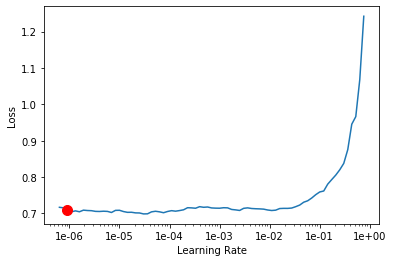

In [110]:
learn.lr_find(wd=1e-2)
learn.recorder.plot(suggestion=True)

In [111]:
learn.load('bestmodel')

set state called


Learner(data=ImageDataBunch;

Train: LabelList (3000 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Close-Up,Close-Up,Close-Up,Close-Up,Close-Up
Path: .;

Valid: LabelList (3105 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Close-Up,Medium,Extreme Wide,Medium,Extreme Close-Up
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06
Min loss divided by 10: 7.59E-08


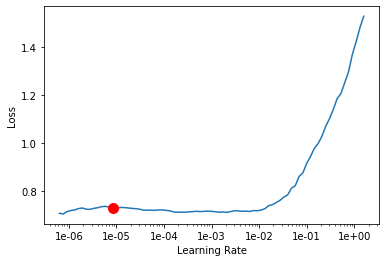

In [112]:
learn.unfreeze()
learn.lr_find(wd=1e-2)
learn.recorder.plot(suggestion=True)

In [117]:
learn.load('bestmodel');
learn.unfreeze();

set state called


In [118]:
fit_with_annealing(learn, 10, 1e-3, annealing_start=.72)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.718876,0.765927,0.860870,0.856776,0.879186,00:44
1,0.706579,0.751706,0.865700,0.865422,0.888033,00:46
2,0.680155,0.760656,0.849919,0.847774,0.879076,00:44
3,0.662280,0.738750,0.872142,0.873235,0.889717,00:43


Better model found at epoch 0 with accuracy value: 0.8608695864677429.
Better model found at epoch 1 with accuracy value: 0.8657004833221436.
Better model found at epoch 3 with accuracy value: 0.8721417188644409.
Better model found at epoch 4 with accuracy value: 0.8740741014480591.
set state called


Why does it stop???? Auto stop on model not improving?

## Ranger + Label Smoothing + Fit w/ Annealing + New Head

Adding a new head and training end to end. <br>
Peaks at **88.2%**

In [119]:
torch.cuda.empty_cache()

In [120]:
learn = cnn_learner(data, models.mobilenet_v2, bn_wd=False, pretrained=True,
                    metrics=metrics, opt_func=opt_func, loss_func=loss_func, 
                    callback_fns = partial(SaveModelCallback, monitor='accuracy'))

set state called
set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03
Min loss divided by 10: 5.25E-02


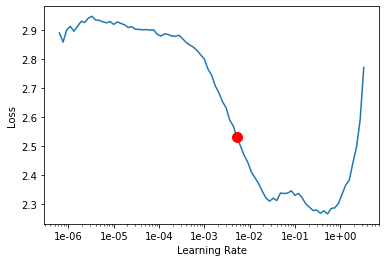

In [121]:
learn.unfreeze()
learn.lr_find(wd=1e-2)
learn.recorder.plot(suggestion=True)

In [122]:
fit_with_annealing(learn, 20, 5e-3, annealing_start=.72)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.527951,1.131579,0.786151,0.786901,0.822976,00:43
1,1.189026,0.905950,0.852496,0.861141,0.859590,00:43
2,1.008822,0.788293,0.878583,0.873293,0.884979,00:42
3,0.882857,0.769582,0.863768,0.862512,0.875875,00:42
4,0.815768,0.756545,0.866989,0.864767,0.877421,00:44
5,0.760466,0.746040,0.872464,0.872610,0.876987,00:43
6,0.720851,0.853199,0.821578,0.821900,0.852694,00:43
7,0.685614,0.776838,0.863768,0.866312,0.878737,00:43
8,0.649977,0.714320,0.877939,0.880908,0.890486,00:43
9,0.631010,0.814560,0.843156,0.844764,0.863191,00:42


Better model found at epoch 0 with accuracy value: 0.7861513495445251.
Better model found at epoch 1 with accuracy value: 0.8524959683418274.
Better model found at epoch 2 with accuracy value: 0.8785829544067383.
Better model found at epoch 19 with accuracy value: 0.8821256160736084.
set state called


## Ranger + Label Smoothing + One Cycle Training + New Head + Training in Stages

Peaks at **88.8%**

In [125]:
learn = cnn_learner(data, models.mobilenet_v2, bn_wd=False, pretrained=True,
                    metrics=metrics, opt_func=opt_func, loss_func=loss_func,
                    callback_fns = partial(SaveModelCallback, monitor='accuracy'))

set state called
set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03
Min loss divided by 10: 5.25E-02


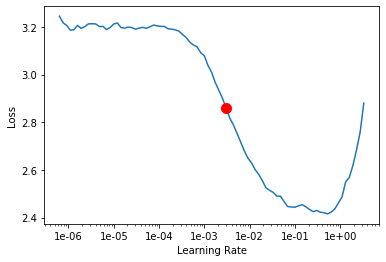

In [127]:
learn.lr_find(wd=1e-2)
learn.recorder.plot(suggestion=True)

In [128]:
learn.fit_one_cycle(8, 5e-3, wd=1e-2)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,2.272520,1.123697,0.723671,0.726465,0.771937,00:40
1,1.565757,1.110222,0.821900,0.833540,0.831702,00:45
2,1.316014,0.847663,0.860870,0.859402,0.871385,00:43
3,1.083816,0.906911,0.841868,0.835196,0.851085,00:43
4,0.925226,0.793750,0.867633,0.861834,0.883198,00:44
5,0.814093,0.757432,0.880515,0.879575,0.889068,00:43
6,0.741487,0.730025,0.885024,0.882505,0.896574,00:45
7,0.694268,0.735218,0.881481,0.873951,0.897856,00:47


Better model found at epoch 0 with accuracy value: 0.7236714959144592.
Better model found at epoch 1 with accuracy value: 0.8219001889228821.
Better model found at epoch 2 with accuracy value: 0.8608695864677429.
Better model found at epoch 4 with accuracy value: 0.8676328659057617.
Better model found at epoch 5 with accuracy value: 0.8805152773857117.
Better model found at epoch 6 with accuracy value: 0.8850241303443909.
set state called


set state called
set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.45E-06


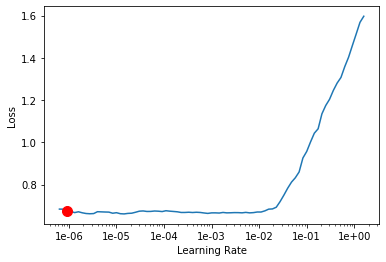

In [129]:
learn.unfreeze()
learn.lr_find(wd=1e-2)
learn.recorder.plot(suggestion=True)

In [132]:
learn.load('bestmodel');

set state called


In [133]:
learn.fit_one_cycle(20, slice(1e-6, 5e-3), wd=1e-2)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.661161,0.720047,0.884380,0.880080,0.897633,00:44
1,0.662441,0.722470,0.884058,0.879466,0.896698,00:41
2,0.659256,0.747130,0.884702,0.879629,0.895786,00:41
3,0.667362,0.787610,0.867633,0.863233,0.890409,00:42
4,0.667263,0.741561,0.885024,0.880342,0.898172,00:41
5,0.657740,0.741288,0.882126,0.879568,0.894352,00:44
6,0.633228,0.738517,0.877295,0.876566,0.887738,00:44
7,0.610533,0.706649,0.876329,0.872765,0.892889,00:44
8,0.594585,0.724082,0.877939,0.874795,0.887059,00:41
9,0.580357,0.694874,0.888567,0.884941,0.897966,00:43


Better model found at epoch 0 with accuracy value: 0.884380042552948.
Better model found at epoch 2 with accuracy value: 0.8847020864486694.
Better model found at epoch 4 with accuracy value: 0.8850241303443909.
Better model found at epoch 9 with accuracy value: 0.8885668516159058.
set state called


## Ranger + Label Smothing + One Cycle Training + New Head

Stopped midway.

In [138]:
learn = cnn_learner(data, models.mobilenet_v2, bn_wd=False, pretrained=True,
                    metrics=metrics, opt_func=opt_func, loss_func=loss_func,
                    callback_fns = partial(SaveModelCallback, monitor='accuracy'))

set state called
set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


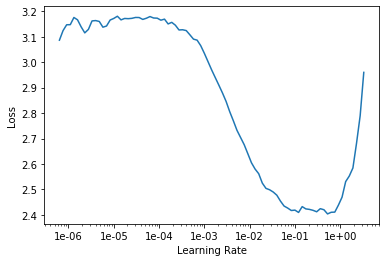

In [134]:
learn.unfreeze()
learn.lr_find(wd=1e-2)
learn.recorder.plot()

In [139]:
learn.fit_one_cycle(25, slice(1e-6, 4e-3), wd=1e-2)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,2.950869,2.021819,0.268277,0.264572,0.294263,00:42
1,2.369485,1.305266,0.580032,0.572227,0.616342,00:43
2,1.878555,1.101519,0.702093,0.700191,0.731344,00:44
3,1.550533,1.048779,0.735266,0.735883,0.770327,00:42
4,1.385539,1.040389,0.751047,0.753036,0.778604,00:41
5,1.277220,1.039987,0.740419,0.744247,0.773073,00:41


Better model found at epoch 0 with accuracy value: 0.26827695965766907.
Better model found at epoch 1 with accuracy value: 0.580032229423523.
Better model found at epoch 2 with accuracy value: 0.7020934224128723.
Better model found at epoch 3 with accuracy value: 0.7352656722068787.
Better model found at epoch 4 with accuracy value: 0.7510467171669006.
set state called


KeyboardInterrupt: 

## Ranger + Label Smoothing + Fit w/ Annealing (Revisited)

The pretrained model is trained end-to-end at once (as oppposed to fitting the head, then unfreezing) and the head is unchanged. <br>
Peaks at **88.6%**, which is already better than our previous supervised baseline model (`MNetV2-150x266-3000L` @86.7%)

In [140]:
learn = Learner(data, model, opt_func, loss_func, metrics, bn_wd=False)

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-03
Min loss divided by 10: 3.31E-01


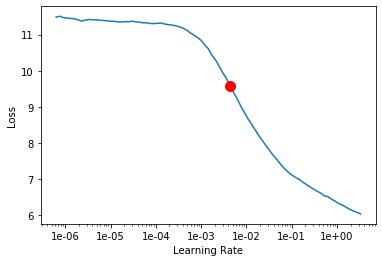

In [141]:
learn.lr_find(wd=1e-2)
learn.recorder.plot(suggestion=True)

In [142]:
fit_with_annealing(learn, num_epoch=20, lr=4e-3, annealing_start=0.72)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,3.241281,2.285449,0.734944,nan,nan,00:47
1,2.017818,1.517803,0.847343,nan,nan,00:44
2,1.611868,1.361297,0.884380,nan,nan,00:46
3,1.426155,1.450114,0.841546,nan,nan,00:49
4,1.341188,1.385875,0.876006,nan,nan,00:48
5,1.286968,1.413310,0.862802,nan,nan,00:48
6,1.252201,1.477066,0.852818,nan,nan,00:49
7,1.249582,1.415312,0.860225,nan,nan,00:46
8,1.235729,1.372829,0.877939,nan,nan,00:47
9,1.205824,1.695824,0.787762,nan,nan,00:50


In [143]:
x

NameError: name 'x' is not defined